In [138]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from sklearn.linear_model import LinearRegression as LR

In [139]:
X_simple,t_simple = simple_dataset(noise=10,n_samples=300)

## feature normalisation

# X_simple = X_simple / X_simple.max()

division_ratio = 0.8
split_point =int(division_ratio * len(X_simple)) 

X_train_simple = X_simple[:split_point]
X_test_simple = X_simple[split_point:]

t_train_simple = t_simple[:split_point]
t_test_simple = t_simple[split_point:]


X_complex,t_complex = remodel_complex_dataset()

split_point =int(division_ratio * len(X_complex)) 

X_train_complex = X_complex[:split_point]
X_test_complex = X_complex[split_point:]

t_train_complex = t_complex[:split_point]
t_test_complex = t_complex[split_point:]


X_complex_default,t_complex_default = complex_dataset()
# X_complex_default = np.reshape(X_complex_default,X_complex_default.shape[0])
X_complex_default = X_complex_default[:,np.newaxis]

split_point =int(division_ratio * len(X_complex_default))

X_train_complex_default = X_complex_default[:split_point]
X_test_complex_default = X_complex_default[split_point:]

t_train_complex_default = t_complex_default[:split_point]
t_test_complex_default = t_complex_default[split_point:]


print(X_simple.dtype)

print(X_train_simple.shape)
print(t_train_simple.shape)

print(X_train_complex.shape)
print(t_train_complex.shape)

print(X_test_complex.shape)
print(t_test_complex.shape)

print(X_complex_default.shape,t_complex_default.shape)

float64
(240, 1)
(240,)
(229, 13)
(229,)
(58, 13)
(58,)
(300, 1) (300,)


In [140]:
class LinearRegression(object):

    def __init__(self, learning_rate=0.01, epochs=1000, eps=1e-6):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.eps = eps
        ## [(epoch,error)]
        self.errors = []

    def fit(self, X, t):

        N, D = X.shape
        
        self.w = np.zeros(D)
        prev_w = self.w 
        prev_cost = self.cost(X,t)

        for ep in range(self.epochs):
            g = self.gradient(X,t)
            step = self.learning_rate * g
            self.w = self.w - step
            
            prev_cost = self.cost(X,t)

            self.errors += [(ep,prev_cost)]

            if np.linalg.norm(self.w - prev_w) < self.eps:
                print("Tolerance broke for: ",self.w,prev_w)
                break

            prev_w = self.w

        print("Done with all epochs")

        # return self

    def predict(self, X, return_std=False):

        N, D = X.shape

        y = X @ self.w
        # print(X.shape,y.shape,"IN predict")
        
        return y

    
    ## Not 1 / n 
    def cost(self,X,t,return_std=False):
        y = self.predict(X,return_std)
        loss = (y - t) ** 2
        
        print("Loss:",np.mean(loss))
        # return 0.5 * loss
        return np.mean(loss)

    def gradient(self,X,t):
        y = self.predict(X)
        # print("In gradient X is: ", X.shape,"T is: ",t.shape,"Y is: ",y.shape," Modified is: ",y.reshape(-1,1).shape )
        d_bias =  -2*sum(t - y)
        # print("D_BIAS:",d_bias)
        d_w = -2*sum(X[:,1:] * (t - y).reshape(-1,1))
        # print("D_W:",d_w,d_w.dtype)
        g = np.append(np.array(d_bias), d_w) 
        return g / X.shape[0] 
        # return g / 2 

In [141]:
def extract_polynomial_features(X, M):
    phi = X
    return np.array([x ** np.arange(M + 1) for x in phi])

In [142]:
class LinearRegressionMB(object):

    def __init__(self, learning_rate=0.01, epochs=1000, eps=1e-6):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.eps = eps
        ## [(epoch,error)]
        self.errors = []
        self.batch_errors = [(0,10)]

    def fit(self, X, t,batch_size=32,reshuffle=False):

        N, D = X.shape
        new_t = t[:,np.newaxis]
        
        self.w = np.zeros(D)
        prev_w = self.w 
        prev_cost = self.cost(X,t)

        if not reshuffle:
            mini_batches = self.create_mini_batches(X, new_t, batch_size)
        for ep in range(self.epochs):
            if reshuffle:
                mini_batches = self.create_mini_batches(X, new_t, batch_size)
                
            for mini_batch in mini_batches:
                X_mini, t_mini = mini_batch

                t_mini = t_mini[:,0]
                
                # print(X_mini.shape)
                if X_mini.shape[0] == 0:
                    # print(X_mini)
                    continue
                
                g = self.gradient(X_mini,t_mini)
                step = self.learning_rate * g
                self.w = self.w - step

                ## aici pune costu per batch
                
                self.batch_errors += [(self.batch_errors[-1][0] + 1,self.cost(X,t))]

            if np.linalg.norm(self.w - prev_w) < self.eps:
                print("Tolerance broke for: ",self.w,prev_w)
                break

            prev_w = self.w
            
            prev_cost = self.cost(X,t)
            self.errors += [(ep,prev_cost)]

        print("Done with all epochs")

        # return self

    def predict(self, X, return_std=False):

        N, D = X.shape

        # print("IN PREDICT",X.shape,self.w.shape)
        y = X @ self.w
        # print(X.shape,y.shape,"IN predict")
        
        return y

    ## https://www.geeksforgeeks.org/ml-mini-batch-gradient-descent-with-python/
    def create_mini_batches(self,X, t, batch_size):
        mini_batches = []
        data = np.hstack((X, t))
        np.random.shuffle(data)
        n_minibatches = data.shape[0] // batch_size
        i = 0

        for i in range(n_minibatches + 1):
            mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
            X_mini = mini_batch[:, :-1]
            Y_mini = mini_batch[:, -1].reshape((-1, 1))
            mini_batches.append((X_mini, Y_mini))
        if data.shape[0] % batch_size != 0:
            mini_batch = data[i * batch_size:data.shape[0]]
            X_mini = mini_batch[:, :-1]
            Y_mini = mini_batch[:, -1].reshape((-1, 1))
            mini_batches.append((X_mini, Y_mini))
        
        return mini_batches
    
    ## Not 1 / n 
    def cost(self,X,t,return_std=False):
        y = self.predict(X,return_std)
        loss = (y - t) ** 2
        # return 0.5 * loss
        return np.mean(loss)

    def gradient(self,X,t):
        y = self.predict(X)
        d_bias =  -2*sum(t - y)
        # print("IN GRADIENT",X[:,1:].shape)
        d_w = -2*sum(X[:,1:] * (t - y).reshape(-1,1))
        g = np.append(np.array(d_bias), d_w) 
        return g / X.shape[0] 
        # return g / 2 

    def plot_epoch_errors(self):
        err = self.errors
        plot_error_x = [ep[0] for ep in err]
        plot_error_y = [ep[1] for ep in err]

        fig = plt.figure(figsize=(10, 8))
        plt.xlabel("Epoch")
        plt.ylabel("MSE")
        plt.scatter(plot_error_x,plot_error_y)
        plt.plot(plot_error_x,plot_error_y)
        plt.show()


Done with all epochs


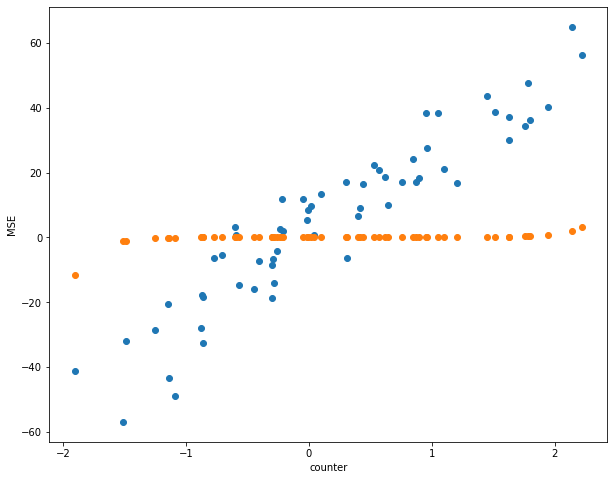

In [143]:
model = LinearRegressionMB(epochs=500,learning_rate=0.00000000005)
M = 11
X_train_feat = extract_polynomial_features(X_train_simple,M) 
X_test_feat = extract_polynomial_features(X_test_simple,M)

model.fit(X_train_feat,t_train_simple,batch_size=1)
y_test = model.predict(X_test_feat)

fig = plt.figure(figsize=(10, 8))
plt.xlabel("counter")
plt.ylabel("MSE")
plt.scatter(X_test_simple,t_test_simple)
plt.scatter(X_test_simple,y_test)
# plt.plot([i[0] for i in model.batch_errors],[i[1] for i in model.batch_errors])
plt.show()

Done with all epochs


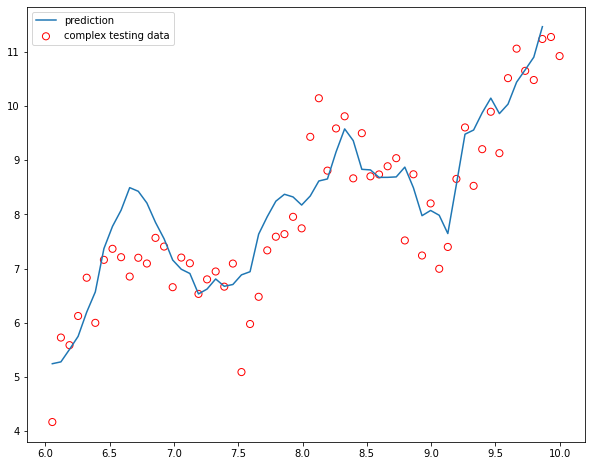

In [155]:
model = LinearRegressionMB(epochs=500,learning_rate=0.00015)
points = 10

X_complex,t_complex = remodel_complex_dataset()

split_point =int(division_ratio * len(X_complex)) 

X_train_complex = X_complex[:split_point]
X_test_complex = X_complex[split_point:]

t_train_complex = t_complex[:split_point]
t_test_complex = t_complex[split_point:]

model.fit(X_train_complex,t_train_complex,batch_size=1)
y_test_hahaha = model.predict(X_test_complex)


fig = plt.figure(figsize=(10, 8))
plt.scatter(X_test_complex_default, t_test_complex_default, facecolor="none", edgecolor="r", s=50, label="complex testing data")
min_len = min(X_test_complex_default.shape[0],y_test_hahaha.shape[0])
plt.plot(X_test_complex_default[:min_len],y_test_hahaha[:min_len],label='prediction')
plt.legend()
plt.show()


Tolerance broke for:  [48.41212885] [48.41212801]
Done with all epochs


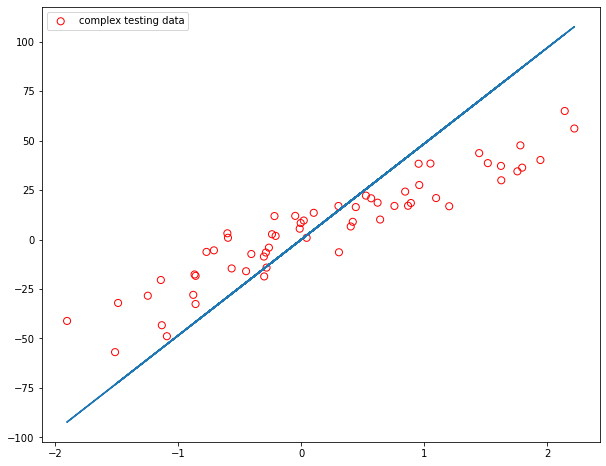

In [168]:
model = LinearRegressionMB(epochs=500,learning_rate=0.1)
points = 12

model.fit(X_train_simple,t_train_simple,batch_size=1)
y = model.predict(X_test_simple)

fig = plt.figure(figsize=(10, 8))
plt.scatter(X_test_simple, t_test_simple, facecolor="none", edgecolor="r", s=50, label="complex testing data")
plt.plot(X_test_simple,y)
plt.legend()
plt.show()
